# 👾 PixelCNN from scratch

In this notebook, we'll walk through the steps required to train your own PixelCNN on the fashion MNIST dataset from scratch

The code has been adapted from the excellent [PixelCNN tutorial](https://keras.io/examples/generative/pixelcnn/) created by ADMoreau, available on the Keras website.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks

%cd /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks

from utils import display

2023-07-22 13:55:40.976593: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-22 13:55:41.225491: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-22 13:55:41.225507: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-07-22 13:55:41.252858: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-22 13:55:41.898078: W tensorflow/stream_executor/platform/de

/home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks


## 0. Parameters <a name="parameters"></a>

In [2]:
IMAGE_SIZE = 16
PIXEL_LEVELS = 4
N_FILTERS = 128
RESIDUAL_BLOCKS = 5
BATCH_SIZE = 128
EPOCHS = 150

## 1. Prepare the data <a name="prepare"></a>

In [3]:
# Load the data
(x_train, _), (_, _) = datasets.fashion_mnist.load_data()

In [4]:
# Preprocess the data
def preprocess(imgs_int):
    imgs_int = np.expand_dims(imgs_int, -1)
    imgs_int = tf.image.resize(imgs_int, (IMAGE_SIZE, IMAGE_SIZE)).numpy()
    imgs_int = (imgs_int / (256 / PIXEL_LEVELS)).astype(int) # This is converting all the pixel values to {0, 1, 2, 3}
    imgs = imgs_int.astype("float32")
    imgs = imgs / PIXEL_LEVELS # This is converting all the images to have values in {0, 0.25, 0.5, 0.75} we we can 
    # predict a value
    return imgs, imgs_int

input_data, output_data = preprocess(x_train)
print(f'Unique pixel values of the input', np.unique(input_data[0]))
print(f'Unique pixel values of the output', np.unique(output_data[0]))

Unique pixel values of the input [0.   0.25 0.5  0.75]
Unique pixel values of the output [0 1 2 3]


2023-07-22 13:55:43.654496: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-22 13:55:43.654750: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-22 13:55:43.654799: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-07-22 13:55:43.654834: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-07-22 13:55:43.654867: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

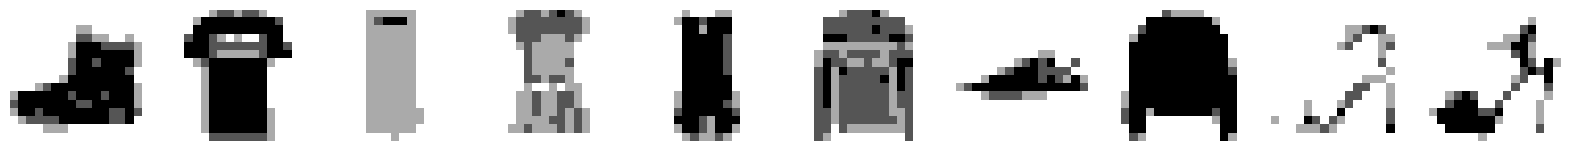

In [5]:
# Show some items of clothing from the training set
display(input_data)

## 2. Build the PixelCNN

## Mathematical Overview

In the *PixelCNN*, we are taking the idea of an autoregressive model and applying it to images. Normally, there is no real sequential nature to images, but we can use a *Masked Convolutional Layer* and a *Residual Layer* to make it so. The masked convolutional layer is just a regular convolutional layer but with a mask (ones and zeros) applied on the pixel after and/including the middle one. What this means is that the convolution can only see what comes up to (and/or including) the middle pixel, and nothing after it. This looks like:

<div style='text-align: center;'>
    <img src='/home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/Graphics/MaskedConv.png' alt='MaskedConv' width='500'>
</div>

A residual layer is one in which the original input $\mathbf{x}$ is add to the output of the layer $\mathcal{F}(\mathbf{x})$. This looks like:

<div style='text-align: center;'>
    <img src='/home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/Graphics/Residual_Layer.png' alt='Residual_Layer' width='500'>
</div>

In this implementation, our residual layer is simply a convolutional layer, then a masked convolutional layer, another convolutional layer, and then an addition layer to add the input and the output of the layer.

Now, the way this works is that when the masked conv is type A, so the middle pixel is masked out with zero, then the kernel has to learn how to fill in that pixel without the pixel value itself, using only the pixels that came before it. This is used in the beginning of the model, as we want the model to guess that pixel value. When it is in mode B, it has the guessed pixel value and the ones before it and it can improve the guess. The residual layer has several uses, including helping with the vanishing gradient problem, but for us, it allows the model to learn an identity function more easily. If the input is better before passing through the layer, then without the *skip connection*, bringing it to the end of the layer, the model would have to learn the identity function in the layer. But now, it can simply make the weights in the layer small or zero, as they don't matter anymore. This is easier to learn.

In [6]:
# The first layer is the PixelCNN layer. This layer simply
# builds on the 2D convolutional layer, but includes masking.
class MaskedConv2D(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super(MaskedConv2D, self).__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs) # MaskedConv2D is based on the regular convolutional layer

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0 # Every pixel in the preceeding rows are unmasked with 1
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0 # The pixels in the preceeding columns that are in the same row are unmasked with 1
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0 # The central pixel is unmasked with 1. Otherwise (type A), the central pixel remains masked
            # Note, this is happening at kernel_shape[1] // 2, whereas the line above is : kernel_shape[1] // 2, meaning it STOPS at this column. So,
            # adding it here unmasks that cell specifically
    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask) # Mask is multilplied by filter weights to effectively render them mute
        return self.conv(inputs)

    def get_config(self):
        cfg = super().get_config()
        return cfg
    
'''
This is going to create a mask that has all ones leading up to the middle cell
'''

'\nThis is going to create a mask that has all ones leading up to the middle cell\n'

In [7]:
class ResidualBlock(layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = layers.Conv2D(
            filters=filters // 2, kernel_size=1, activation="relu"
        ) # Takes then input and passes a convolution over it, reducing the feature map by 1/2
        self.pixel_conv = MaskedConv2D(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        ) # Pixel conv layer with feature map half the input. With kernel_size=3, this only looks at five pixels, three in the row above the focus pixel,
        # one to the left, and the focus pixel itself (note the type B)
        self.conv2 = layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        ) # Filters match in input channels

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return layers.add([inputs, x]) # The output, which has the same shape (as our last conv layer had the same filters as the input channels) as the input,
    # is added element-wise to the input to give (batch_size, H_l, W_l, input_channels)

    def get_config(self):
        cfg = super().get_config()
        return cfg

In [8]:
inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1)) # Shape (B, 16, 16, 1)
x = MaskedConv2D(
    mask_type="A",
    filters=N_FILTERS, # Filters, kernel_size, activation, and padding are key words from the layers.Conv2D(**kwargs)
    kernel_size=7, # With kernel_size=7, this only looks at 24 pixels, 21 in the three rows above the focus and 3 to the left. Note the type A means the
    # focus is masked out
    activation="relu",
    padding="same",
)(inputs)

'''
Note, the first layer is a masked conv of type A so at each central pixel of the kernel, the model must guess what it is, as it is masked out.
'''

for _ in range(RESIDUAL_BLOCKS):
    x = ResidualBlock(filters=N_FILTERS)(x)

for _ in range(2):
    x = MaskedConv2D(
        mask_type="B",
        filters=N_FILTERS,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x) # These act as Dense layers for the number of channels of each pixel because of kernel_size=1 because each pixel is only being mutliplied by
    # the kernel value (in each filter)

out = layers.Conv2D(
    filters=PIXEL_LEVELS, # filters-PIXEL_LEVELS means that we have now four channels per pixel
    kernel_size=1,
    strides=1,
    activation="softmax", # Note softmax means for each pixel, we get a probility across the channels
    padding="valid",
)(x) # Final output is an image of the same height and width as the original with four channels, where the channels are a probability vector

pixel_cnn = models.Model(inputs, out)
pixel_cnn.summary()

'''
Note that an output of 4 channels as a probability vector means that when we sample, we are going to get an index between 0 and 3 (num_channels). From there,
recall that the y (called output in the pixel_cnn.fit), has pixel values of only {0,1,2,3}, meaning when we select an integer, we compare it using
sparse categorical cross entropy to get out loss.
'''

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 16, 1)]       0         
                                                                 
 masked_conv2d (MaskedConv2D  (None, 16, 16, 128)      6400      
 )                                                               
                                                                 
 residual_block (ResidualBlo  (None, 16, 16, 128)      53504     
 ck)                                                             
                                                                 
 residual_block_1 (ResidualB  (None, 16, 16, 128)      53504     
 lock)                                                           
                                                                 
 residual_block_2 (ResidualB  (None, 16, 16, 128)      53504     
 lock)                                                       

'\nNote that an output of 4 channels as a probability vector means that when we sample, we are going to get an index between 0 and 3 (num_channels). From there,\nrecall that the y (called output in the pixel_cnn.fit), has pixel values of only {0,1,2,3}, meaning when we select an integer, we compare it using\nsparse categorical cross entropy to get out loss.\n\n, and\nthat index will become the pixel value. We are then going to divide by 4, meaning our final generated image will have pixel values of either\n0, 0.25, 0.5, or 0.75. \n'

## 3. Train the PixelCNN <a name="train"></a>

In [9]:
adam = optimizers.Adam(learning_rate=0.0005)
pixel_cnn.compile(optimizer=adam, loss="sparse_categorical_crossentropy")

In [10]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def sample_from(self, probs, temperature):  # Once we have our probability vectors, this will sample from them
        probs = probs ** (1 / temperature) # This changes the probabilities by a temperature, closer to 0 is more deterministic and 1 is more random
        probs = probs / np.sum(probs) # The probabilities no longer sum to one, so we normalize them
        return np.random.choice(len(probs), p=probs) # Sampling a single value from the probabilities

    def generate(self, temperature):
        generated_images = np.zeros(
            shape=(self.num_img,) + (pixel_cnn.input_shape)[1:]
        )
        batch, rows, cols, channels = generated_images.shape

        for row in range(rows):
            for col in range(cols):
                for channel in range(channels): # Iterating over the channels, which is one
                    probs = self.model.predict(generated_images, verbose=0)[
                        :, row, col, :
                    ] # This will generate a batch of shape (num_images, H, W, 4)
                    generated_images[:, row, col, channel] = [
                        self.sample_from(x, temperature) for x in probs
                    ] # Sampling along the channels an returning an index as the channel value (so, in {0,1,2,3})
                    generated_images[:, row, col, channel] /= PIXEL_LEVELS # Dividing the channel value to make sense, i.e., be in {0, 0.25, 0.5, 0.75}

        return generated_images

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 15 == 0:
            generated_images = self.generate(temperature=1.0)
            display(
                generated_images,
                save_to="/home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/05_autoregressive/02_pixelcnn/output/generated_img_%03d.png" % (epoch),
            )


img_generator_callback = ImageGenerator(num_img=10)

Epoch 1/150
469/469 [==============================] - ETA: 0s - loss: 0.4895
Saved to /home/clachris/Documents/projects/Generative_Deep_Learning_2nd_Edition/notebooks/05_autoregressive/02_pixelcnn/output/generated_img_000.png


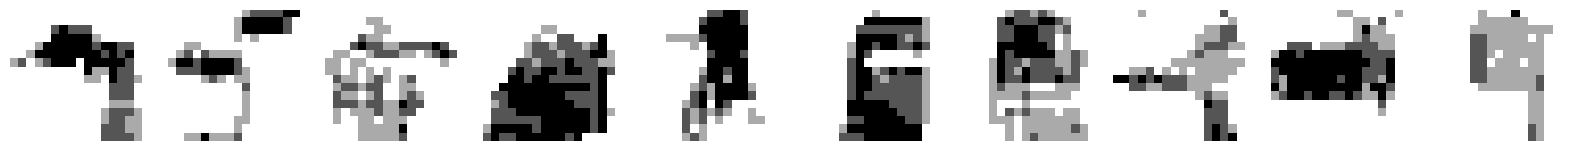

469/469 [==============================] - 112s 238ms/step - loss: 0.4895
Epoch 2/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3993
Epoch 3/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3869
Epoch 4/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3803
Epoch 5/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3755
Epoch 6/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3714
Epoch 7/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3685
Epoch 8/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3658
Epoch 9/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3631
Epoch 10/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3606
Epoch 11/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3589
Epoch 12/150
469/469 [==============================] - 96s 205ms/step - l

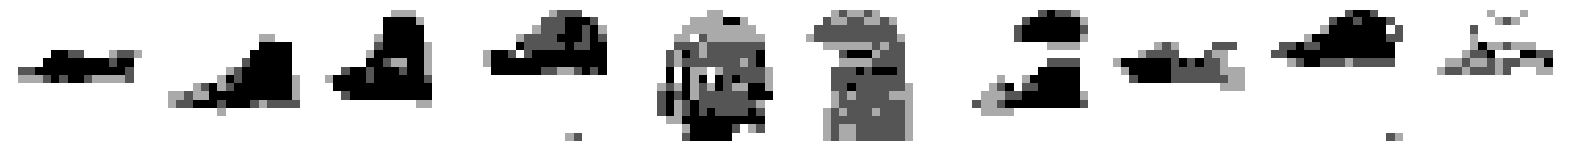

469/469 [==============================] - 104s 222ms/step - loss: 0.3516
Epoch 17/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3504
Epoch 18/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3494
Epoch 19/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3485
Epoch 20/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3477
Epoch 21/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3469
Epoch 22/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3461
Epoch 23/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3455
Epoch 24/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3450
Epoch 25/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3441
Epoch 26/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3437
Epoch 27/150
469/469 [==============================] - 97s 206ms/

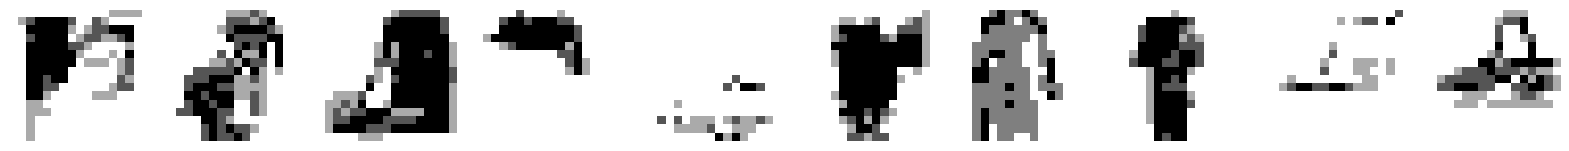

469/469 [==============================] - 104s 223ms/step - loss: 0.3411
Epoch 32/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3405
Epoch 33/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3402
Epoch 34/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3396
Epoch 35/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3394
Epoch 36/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3390
Epoch 37/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3385
Epoch 38/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3384
Epoch 39/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3378
Epoch 40/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3375
Epoch 41/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3374
Epoch 42/150
469/469 [==============================] - 96s 205ms/

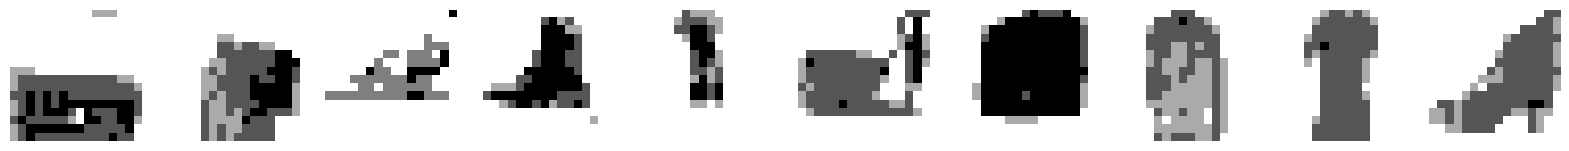

469/469 [==============================] - 104s 222ms/step - loss: 0.3358
Epoch 47/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3355
Epoch 48/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3352
Epoch 49/150
469/469 [==============================] - 96s 204ms/step - loss: 0.3351
Epoch 50/150
469/469 [==============================] - 96s 204ms/step - loss: 0.3347
Epoch 51/150
469/469 [==============================] - 96s 204ms/step - loss: 0.3346
Epoch 52/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3342
Epoch 53/150
469/469 [==============================] - 96s 204ms/step - loss: 0.3339
Epoch 54/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3340
Epoch 55/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3337
Epoch 56/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3334
Epoch 57/150
469/469 [==============================] - 96s 205ms/

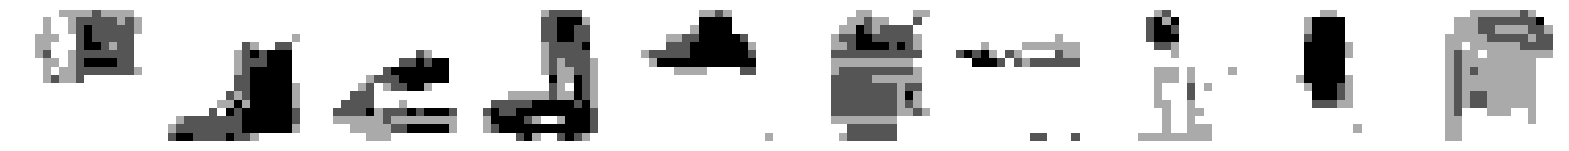

469/469 [==============================] - 105s 223ms/step - loss: 0.3325
Epoch 62/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3321
Epoch 63/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3320
Epoch 64/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3318
Epoch 65/150
469/469 [==============================] - 97s 207ms/step - loss: 0.3316
Epoch 66/150
469/469 [==============================] - 97s 207ms/step - loss: 0.3317
Epoch 67/150
469/469 [==============================] - 97s 207ms/step - loss: 0.3312
Epoch 68/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3312
Epoch 69/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3309
Epoch 70/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3307
Epoch 71/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3307
Epoch 72/150
469/469 [==============================] - 96s 205ms/

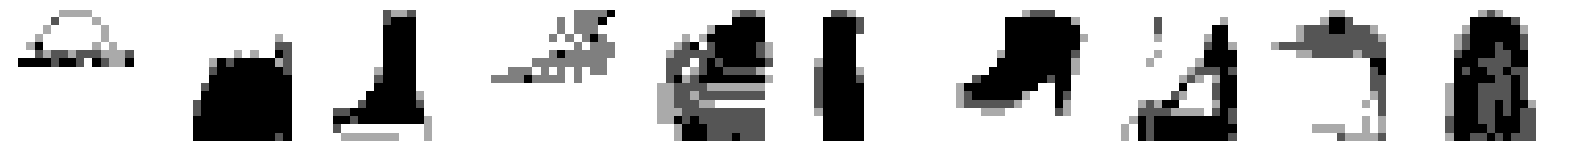

469/469 [==============================] - 104s 222ms/step - loss: 0.3300
Epoch 77/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3298
Epoch 78/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3295
Epoch 79/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3294
Epoch 80/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3295
Epoch 81/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3292
Epoch 82/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3291
Epoch 83/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3290
Epoch 84/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3288
Epoch 85/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3287
Epoch 86/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3287
Epoch 87/150
469/469 [==============================] - 96s 205ms/

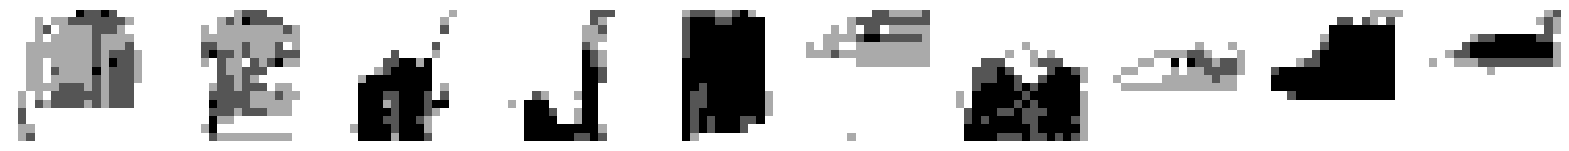

469/469 [==============================] - 105s 223ms/step - loss: 0.3279
Epoch 92/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3279
Epoch 93/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3278
Epoch 94/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3278
Epoch 95/150
469/469 [==============================] - 96s 206ms/step - loss: 0.3274
Epoch 96/150
469/469 [==============================] - 96s 206ms/step - loss: 0.3275
Epoch 97/150
469/469 [==============================] - 96s 206ms/step - loss: 0.3274
Epoch 98/150
469/469 [==============================] - 96s 206ms/step - loss: 0.3273
Epoch 99/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3271
Epoch 100/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3271
Epoch 101/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3271
Epoch 102/150
469/469 [==============================] - 97s 208

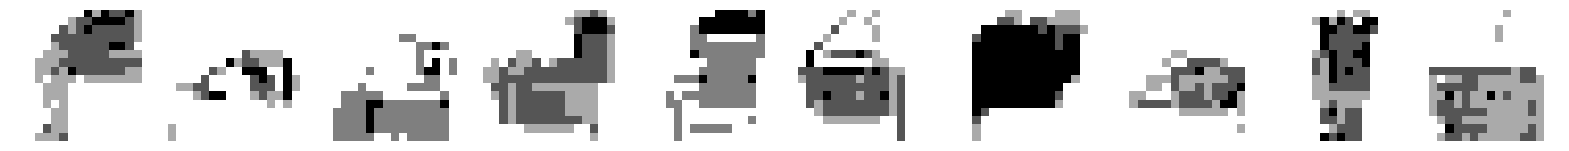

469/469 [==============================] - 104s 222ms/step - loss: 0.3265
Epoch 107/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3263
Epoch 108/150
469/469 [==============================] - 96s 206ms/step - loss: 0.3261
Epoch 109/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3263
Epoch 110/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3261
Epoch 111/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3260
Epoch 112/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3259
Epoch 113/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3259
Epoch 114/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3257
Epoch 115/150
469/469 [==============================] - 96s 206ms/step - loss: 0.3256
Epoch 116/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3256
Epoch 117/150
469/469 [==============================] -

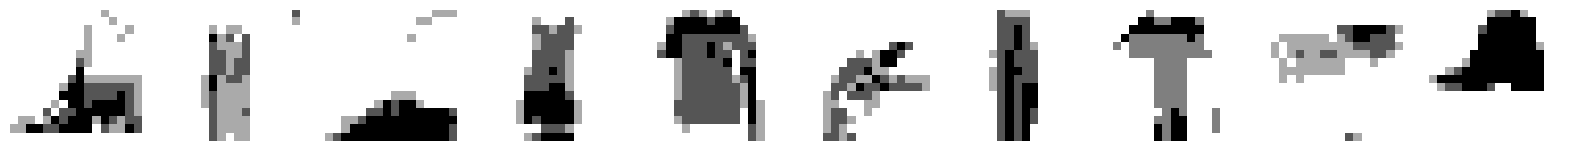

469/469 [==============================] - 105s 223ms/step - loss: 0.3250
Epoch 122/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3252
Epoch 123/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3249
Epoch 124/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3250
Epoch 125/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3247
Epoch 126/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3249
Epoch 127/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3247
Epoch 128/150
469/469 [==============================] - 96s 206ms/step - loss: 0.3246
Epoch 129/150
469/469 [==============================] - 96s 206ms/step - loss: 0.3244
Epoch 130/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3245
Epoch 131/150
469/469 [==============================] - 97s 206ms/step - loss: 0.3244
Epoch 132/150
469/469 [==============================] -

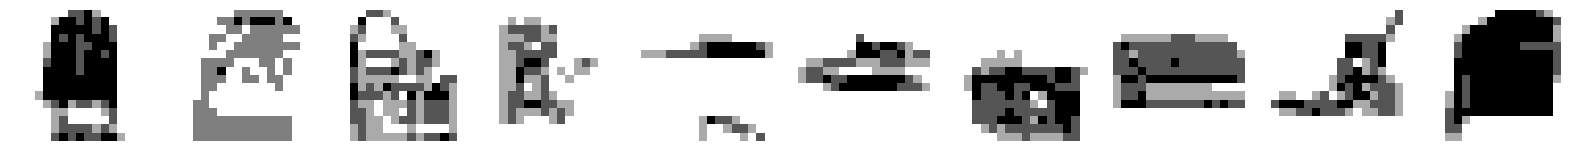

469/469 [==============================] - 105s 224ms/step - loss: 0.3240
Epoch 137/150
469/469 [==============================] - 97s 206ms/step - loss: 0.3239
Epoch 138/150
469/469 [==============================] - 96s 205ms/step - loss: 0.3239
Epoch 139/150
469/469 [==============================] - 97s 208ms/step - loss: 0.3238
Epoch 140/150
469/469 [==============================] - 98s 208ms/step - loss: 0.3238
Epoch 141/150
469/469 [==============================] - 98s 208ms/step - loss: 0.3238
Epoch 142/150
469/469 [==============================] - 97s 207ms/step - loss: 0.3237
Epoch 143/150
469/469 [==============================] - 97s 206ms/step - loss: 0.3237
Epoch 144/150
469/469 [==============================] - 96s 206ms/step - loss: 0.3235
Epoch 145/150
469/469 [==============================] - 97s 206ms/step - loss: 0.3235
Epoch 146/150
469/469 [==============================] - 96s 206ms/step - loss: 0.3233
Epoch 147/150
469/469 [==============================] -

In [12]:
pixel_cnn.fit(
    input_data,
    output_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[tensorboard_callback, img_generator_callback],
)

## 4. Generate images <a name="generate"></a>

In [13]:
generated_images = img_generator_callback.generate(temperature=1.0)

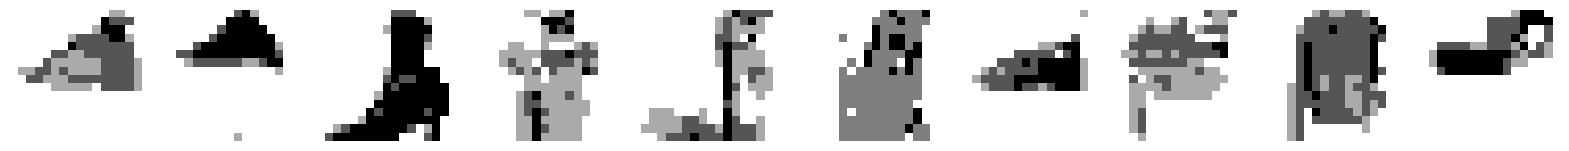

In [14]:
display(generated_images)